In [1]:
import os
import math
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchvision.transforms import v2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from models.model_cnn import KaninchenModel, KaninchenModelResidual
from data.datamodule import BinaryImageDataModule

import optuna
from training.hyperparameter_tuning import CnnOptunaTrainer

c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Configuration

In the following steps, we will load the configuration settings using the `load_configuration` function. The configuration is stored in the `config` variable which will be used throughout the script.

In [2]:
from config.load_configuration import load_configuration
config = load_configuration()

PC Name: DESKTOP-LUKAS
Loaded configuration from config/config_lukas.yaml


### Logging in to Weights & Biases (wandb)

Before starting any experiment tracking, ensure you are logged in to your Weights & Biases (wandb) account. This enables automatic logging of metrics, model checkpoints, and experiment configurations. The following code logs you in to wandb:

```python
wandb.login()
```
If you are running this for the first time, you may be prompted to enter your API key.

In [3]:
# Initialize the Wandb logger
wandb.login()

wandb: Currently logged in as: lukas-pelz (HKA-EKG-Signalverarbeitung) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [4]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [5]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Torch Version:  2.7.0+cu128
Using device:  cuda
Cuda Version:  12.8
NVIDIA GeForce RTX 5060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Defining Transformations and Instantiating DataModule

In this step, we will define the necessary data transformations and initialize the `Animal_DataModule` with the provided configuration.

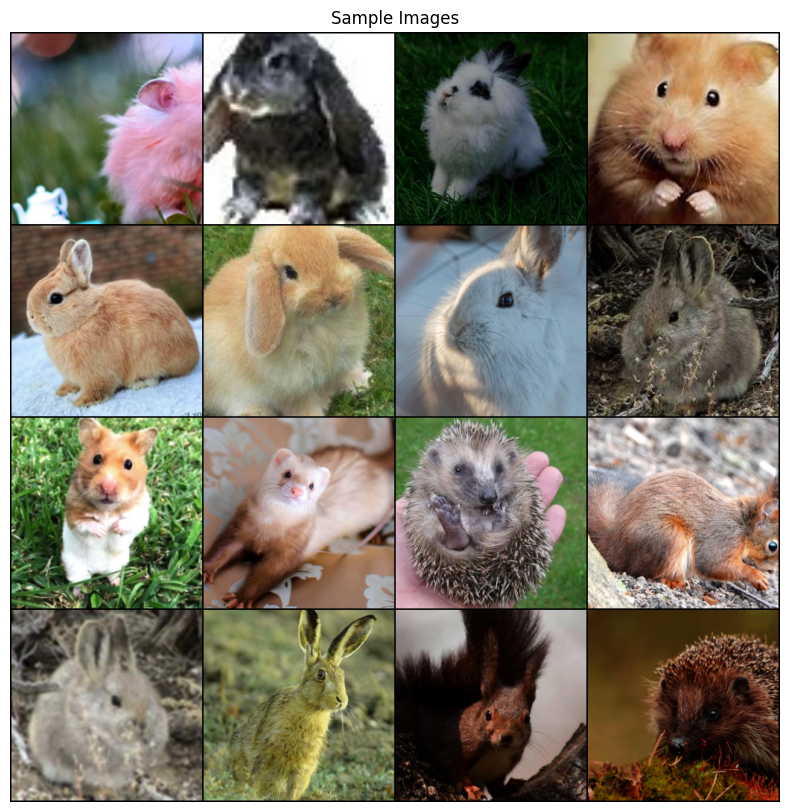

Train dataset size: 10304
Validation dataset size: 2904
Test dataset size: 2909


In [10]:
# TODO: Define transformations here
size = config['image_size']

import data.custom_transforms as custom_transforms
transform = v2.Compose([
    custom_transforms.CenterCropSquare(),
    v2.Resize((size, size)),
    v2.ToTensor(),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dm = BinaryImageDataModule(data_dir=config['path_to_split_aug_pics'], transform=transform, batch_size=config['batch_size'], num_workers=2, persistent_workers=True)
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

# Show a few images from the training set
from torchvision.utils import make_grid
def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:16]  # Show only the first 16 images
    labels = labels[:16]
    grid = make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()
show_images(train_loader)

print('Train dataset size:', len(dm.train_dataset))
print('Validation dataset size:', len(dm.val_dataset))
print('Test dataset size:', len(dm.test_dataset))

### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [9]:
#model = CatsDogsModel()
# model = KaninchenModel()
model = KaninchenModelResidual()
print(ModelSummary(model, max_depth=-1))  
print(type(model).__name__)

   | Name                | Type              | Params | Mode 
-------------------------------------------------------------------
0  | criterion           | BCEWithLogitsLoss | 0      | train
1  | sigmoid             | Sigmoid           | 0      | train
2  | model               | Sequential        | 1.1 M  | train
3  | model.0             | Conv2d            | 896    | train
4  | model.1             | BatchNorm2d       | 64     | train
5  | model.2             | ReLU              | 0      | train
6  | model.3             | MaxPool2d         | 0      | train
7  | model.4             | Conv2d            | 18.5 K | train
8  | model.5             | BatchNorm2d       | 128    | train
9  | model.6             | ReLU              | 0      | train
10 | model.7             | MaxPool2d         | 0      | train
11 | model.8             | Conv2d            | 73.9 K | train
12 | model.9             | BatchNorm2d       | 256    | train
13 | model.10            | ReLU              | 0      | train
14

### Training the Model and Logging with Weights & Biases

In this step, we initialize the Wandb logger and configure the experiment name to include a timestamp for better tracking. The `Trainer` from PyTorch Lightning is set up with the Wandb logger and an early stopping callback to monitor validation loss and prevent overfitting. After training, the Wandb run is finished, and the trained model checkpoint is saved with a unique filename containing the current date and time.

In [7]:
# Initialize the Wandb logger
# add time to the name of the experiment
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M-%S")

# Initialize wandb logger
wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=config['wandb_experiment_name'] + '_' + current_time,
    config={
        #'dataset': 'CIFAR-binary',
        'dataset': 'Kaninchen',
        'batch_size': config['batch_size'],
        'max_epochs': config['max_epochs'],
        'learning_rate': config['learning_rate']
    }
)

# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger)

# Training of the model
trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()

# Create a filename with date identifier
model_filename = f"{config['wandb_experiment_name']}_{current_time}.ckpt"

# Save the model's state_dict to the path specified in config
save_path = os.path.join(os.path.dirname(config['path_to_models']), model_filename)
trainer.save_checkpoint(save_path)
print(f"Model checkpoint saved as {save_path}")
config['path_to_model'] = save_path

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'dm' is not defined

#### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization
import datetime
config['sweep_id'] = datetime.datetime.now().strftime("%Y%m%d_%H%M")

def objective(trial):
    model = KaninchenModel                  # or another model's class, depending on your choice
    trainer = CnnOptunaTrainer(
        model=model,                        # Function to create the model
        config=config,
        normalize_mean=None, #[0.485, 0.456, 0.406], 
        normalize_std=None, #[0.229, 0.224, 0.225],
        dataset_name="DwarfRabbits-binary"
    )
    return trainer.run_training(trial)

# Create an Optuna study
study = optuna.create_study(direction="minimize")  # because we minimize val_loss

# Set verbosity to WARNING to reduce output clutter
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the hyperparameter optimization
# study.optimize(objective, n_trials=config['number_of_trials'])
study.optimize(objective, n_trials=3)

# Best result
print("Best trial:")
print(study.best_trial.params)
print("Best value (val_loss):", study.best_value)

[I 2025-06-01 17:18:33,801] A new study created in memory with name: no-name-0ce8d403-f87b-4abc-ba24-06378992bff2
c:\Users\lukas\anaconda3\envs\VDKI-Projekt\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type              | Params | Mode 
--------------------------------------------------------------
0  | criterion      | BCEWithLogitsLoss | 0      | train
1  | sigmoid        | Sigmoid           | 0      | train
2  | model          | Sequential        | 13.1 M | train
3  | train_accuracy | BinaryAccuracy    | 0      | train
4  | val_accuracy   | BinaryAccuracy    | 0      | train
5  | val_precision  | BinaryPrecision   | 0      | train
6  | val_recall     | BinaryRecall      | 0      | train
7  | test_accuracy  | BinaryAccuracy    | 0      | train
8  | conv1          | Sequential        | 39.0 K | train
9  | conv2          | Sequential        | 221 K  | train
10 | conv3          | Sequential        | 886 K  | train
11 | conv4          | Sequential        | 3.5 M  | train
12 | conv5          | Sequential        | 3.5 M  | train
13 | cnn            | Sequential        | 4.7 M  | train
14 | classifier     | Sequential       

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

# Predict with the Model


In [ ]:
# from PIL import Image
# import torch
# # Load the saved model weights from the path specified in config

# def predict_image(path, model):
#     transform = transforms.Compose([
#         transforms.Resize((150, 150)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5]*3, [0.5]*3)
#     ])

#     img = Image.open(path).convert('RGB')
#     img = transform(img).unsqueeze(0)  # Add batch dimension

#     model.eval()
#     with torch.no_grad():
#         pred = model(img)
#         result = "Dog" if pred.item() > 0.5 else "Cat"
#     print(f"Prediction: {result}")


### Loading and Evaluating the Trained Model

The trained model is loaded from the checkpoint specified in the configuration. If the checkpoint exists, the model weights are restored and the model is set to evaluation mode. PyTorch Lightning's `Trainer` is then used to evaluate the model on the test dataset, providing a streamlined way to assess model performance after training.

In [ ]:
model_path = config['path_to_model']
if model_path and os.path.exists(model_path):
    #model = CatsDogsModel.load_from_checkpoint(model_path, map_location=device)
    model = KaninchenModel.load_from_checkpoint(model_path, map_location=device)
    print(f"Loaded model weights from {model_path}")
else:
    print("Model path not found or not specified in config.")

# Ensure model is in eval mode
model.eval()

# Pytorch Lightning's Trainer can be used to test the model
trainer = Trainer()
trainer.test(model=model, dataloaders=test_loader)

RuntimeError: Error(s) in loading state_dict for KaninchenModel:
	Missing key(s) in state_dict: "model.0.0.0.weight", "model.0.0.0.bias", "model.0.0.1.weight", "model.0.0.1.bias", "model.0.0.1.running_mean", "model.0.0.1.running_var", "model.0.0.3.weight", "model.0.0.3.bias", "model.0.0.4.weight", "model.0.0.4.bias", "model.0.0.4.running_mean", "model.0.0.4.running_var", "model.0.1.0.weight", "model.0.1.0.bias", "model.0.1.1.weight", "model.0.1.1.bias", "model.0.1.1.running_mean", "model.0.1.1.running_var", "model.0.1.3.weight", "model.0.1.3.bias", "model.0.1.4.weight", "model.0.1.4.bias", "model.0.1.4.running_mean", "model.0.1.4.running_var", "model.0.2.0.weight", "model.0.2.0.bias", "model.0.2.1.weight", "model.0.2.1.bias", "model.0.2.1.running_mean", "model.0.2.1.running_var", "model.0.2.3.weight", "model.0.2.3.bias", "model.0.2.4.weight", "model.0.2.4.bias", "model.0.2.4.running_mean", "model.0.2.4.running_var", "model.0.3.0.weight", "model.0.3.0.bias", "model.0.3.1.weight", "model.0.3.1.bias", "model.0.3.1.running_mean", "model.0.3.1.running_var", "model.0.3.3.weight", "model.0.3.3.bias", "model.0.3.4.weight", "model.0.3.4.bias", "model.0.3.4.running_mean", "model.0.3.4.running_var", "model.1.1.weight", "model.1.1.bias", "model.1.4.weight", "model.1.4.bias", "conv1.0.weight", "conv1.0.bias", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv1.3.weight", "conv1.3.bias", "conv1.4.weight", "conv1.4.bias", "conv1.4.running_mean", "conv1.4.running_var", "conv2.0.weight", "conv2.0.bias", "conv2.1.weight", "conv2.1.bias", "conv2.1.running_mean", "conv2.1.running_var", "conv2.3.weight", "conv2.3.bias", "conv2.4.weight", "conv2.4.bias", "conv2.4.running_mean", "conv2.4.running_var", "conv3.0.weight", "conv3.0.bias", "conv3.1.weight", "conv3.1.bias", "conv3.1.running_mean", "conv3.1.running_var", "conv3.3.weight", "conv3.3.bias", "conv3.4.weight", "conv3.4.bias", "conv3.4.running_mean", "conv3.4.running_var", "conv4.0.weight", "conv4.0.bias", "conv4.1.weight", "conv4.1.bias", "conv4.1.running_mean", "conv4.1.running_var", "conv4.3.weight", "conv4.3.bias", "conv4.4.weight", "conv4.4.bias", "conv4.4.running_mean", "conv4.4.running_var", "conv5.0.weight", "conv5.0.bias", "conv5.1.weight", "conv5.1.bias", "conv5.1.running_mean", "conv5.1.running_var", "conv5.3.weight", "conv5.3.bias", "conv5.4.weight", "conv5.4.bias", "conv5.4.running_mean", "conv5.4.running_var", "cnn.0.0.weight", "cnn.0.0.bias", "cnn.0.1.weight", "cnn.0.1.bias", "cnn.0.1.running_mean", "cnn.0.1.running_var", "cnn.0.3.weight", "cnn.0.3.bias", "cnn.0.4.weight", "cnn.0.4.bias", "cnn.0.4.running_mean", "cnn.0.4.running_var", "cnn.1.0.weight", "cnn.1.0.bias", "cnn.1.1.weight", "cnn.1.1.bias", "cnn.1.1.running_mean", "cnn.1.1.running_var", "cnn.1.3.weight", "cnn.1.3.bias", "cnn.1.4.weight", "cnn.1.4.bias", "cnn.1.4.running_mean", "cnn.1.4.running_var", "cnn.2.0.weight", "cnn.2.0.bias", "cnn.2.1.weight", "cnn.2.1.bias", "cnn.2.1.running_mean", "cnn.2.1.running_var", "cnn.2.3.weight", "cnn.2.3.bias", "cnn.2.4.weight", "cnn.2.4.bias", "cnn.2.4.running_mean", "cnn.2.4.running_var", "cnn.3.0.weight", "cnn.3.0.bias", "cnn.3.1.weight", "cnn.3.1.bias", "cnn.3.1.running_mean", "cnn.3.1.running_var", "cnn.3.3.weight", "cnn.3.3.bias", "cnn.3.4.weight", "cnn.3.4.bias", "cnn.3.4.running_mean", "cnn.3.4.running_var", "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias". 
	Unexpected key(s) in state_dict: "init_conv.0.weight", "init_conv.0.bias", "init_conv.1.weight", "init_conv.1.bias", "init_conv.1.running_mean", "init_conv.1.running_var", "init_conv.1.num_batches_tracked", "layer1.0.weight", "layer1.0.bias", "layer1.1.weight", "layer1.1.bias", "layer1.1.running_mean", "layer1.1.running_var", "layer1.1.num_batches_tracked", "layer1.3.weight", "layer1.3.bias", "layer1.4.weight", "layer1.4.bias", "layer1.4.running_mean", "layer1.4.running_var", "layer1.4.num_batches_tracked", "layer2.0.weight", "layer2.0.bias", "layer2.1.weight", "layer2.1.bias", "layer2.1.running_mean", "layer2.1.running_var", "layer2.1.num_batches_tracked", "layer2.3.weight", "layer2.3.bias", "layer2.4.weight", "layer2.4.bias", "layer2.4.running_mean", "layer2.4.running_var", "layer2.4.num_batches_tracked", "layer3.0.weight", "layer3.0.bias", "layer3.1.weight", "layer3.1.bias", "layer3.1.running_mean", "layer3.1.running_var", "layer3.1.num_batches_tracked", "layer3.3.weight", "layer3.3.bias", "layer3.4.weight", "layer3.4.bias", "layer3.4.running_mean", "layer3.4.running_var", "layer3.4.num_batches_tracked", "layer4.conv_block.0.weight", "layer4.conv_block.0.bias", "layer4.conv_block.1.weight", "layer4.conv_block.1.bias", "layer4.conv_block.1.running_mean", "layer4.conv_block.1.running_var", "layer4.conv_block.1.num_batches_tracked", "layer4.conv_block.3.weight", "layer4.conv_block.3.bias", "layer4.conv_block.4.weight", "layer4.conv_block.4.bias", "layer4.conv_block.4.running_mean", "layer4.conv_block.4.running_var", "layer4.conv_block.4.num_batches_tracked", "layer4.skip.0.weight", "layer4.skip.0.bias", "layer4.skip.1.weight", "layer4.skip.1.bias", "layer4.skip.1.running_mean", "layer4.skip.1.running_var", "layer4.skip.1.num_batches_tracked", "fc.weight", "fc.bias", "model.4.weight", "model.4.bias", "model.5.weight", "model.5.bias", "model.5.running_mean", "model.5.running_var", "model.5.num_batches_tracked", "model.8.weight", "model.8.bias", "model.9.weight", "model.9.bias", "model.9.running_mean", "model.9.running_var", "model.9.num_batches_tracked", "model.13.weight", "model.13.bias", "model.16.weight", "model.16.bias", "model.0.weight", "model.0.bias", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.1.num_batches_tracked". 